In [45]:
from explainn import tools
from explainn import networks
from explainn import train
from explainn import test
from explainn import interpretation

from Bio import SeqIO
import torch
import os
import torch.nn as nn
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import logomaker
import math
import h5py
import copy
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

# Loading the data

In [ ]:
# data is from PMID: 35551305

In [7]:
train_sequences = {}
fasta_sequences = SeqIO.parse(open("../../DeepSTARR_data/Sequences_Train.fa"),'fasta')
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    train_sequences[name] = sequence.upper()
    
val_sequences = {}
fasta_sequences = SeqIO.parse(open("../../DeepSTARR_data/Sequences_Val.fa"),'fasta')
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    val_sequences[name] = sequence.upper()
    
test_sequences = {}
fasta_sequences = SeqIO.parse(open("../../DeepSTARR_data/Sequences_Test.fa"),'fasta')
for fasta in fasta_sequences:
    name, sequence = fasta.id, str(fasta.seq)
    test_sequences[name] = sequence.upper()
    
train_sequences = pd.Series(train_sequences)
val_sequences = pd.Series(val_sequences)
test_sequences = pd.Series(test_sequences)

#getting activity
Activity = pd.read_table("../../DeepSTARR_data/Sequences_activity_Train.txt")
Y_train = Activity.loc[:,["Dev_log2_enrichment", "Hk_log2_enrichment"]]
Y_train.index = train_sequences.index

Activity = pd.read_table("../../DeepSTARR_data/Sequences_activity_Val.txt")
Y_val = Activity.loc[:,["Dev_log2_enrichment", "Hk_log2_enrichment"]]
Y_val.index = val_sequences.index

Activity = pd.read_table("../../DeepSTARR_data/Sequences_activity_Test.txt")
Y_test = Activity.loc[:,["Dev_log2_enrichment", "Hk_log2_enrichment"]]
Y_test.index = test_sequences.index

#removing Ns
s = train_sequences.apply(lambda x: "N" in x)
Y_train = Y_train[~s]
train_sequences = train_sequences[~s]

s = val_sequences.apply(lambda x: "N" in x)
Y_val = Y_val[~s]
val_sequences = val_sequences[~s]

s = test_sequences.apply(lambda x: "N" in x)
Y_test = Y_test[~s]
test_sequences = test_sequences[~s]

#one hot encoding
train_sequences = train_sequences.map(lambda x: tools.dna_one_hot(x, flatten=False))
train_sequences = np.stack(train_sequences, axis=0)

val_sequences = val_sequences.map(lambda x: tools.dna_one_hot(x, flatten=False))
val_sequences = np.stack(val_sequences, axis=0)

test_sequences = test_sequences.map(lambda x: tools.dna_one_hot(x, flatten=False))
test_sequences = np.stack(test_sequences, axis=0)

Y_train = Y_train.values
Y_val = Y_val.values
Y_test = Y_test.values

In [8]:
print(train_sequences.shape)
print(Y_train.shape)
print(val_sequences.shape)
print(Y_val.shape)
print(test_sequences.shape)
print(Y_test.shape)

(402278, 4, 249)
(402278, 2)
(40570, 4, 249)
(40570, 2)
(41186, 4, 249)
(41186, 2)


In [ ]:
h5f = h5py.File("../../DeepSTARR_data/DeepSTARR_data.h5", 'w')

target_labels = [a.encode('utf8') for a in ["Dev_log2_enrichment", "Hk_log2_enrichment"]]
h5f.create_dataset('target_labels', data=target_labels)

h5f.create_dataset('train_in', data=train_sequences)
h5f.create_dataset('train_out', data=Y_train)

h5f.create_dataset('valid_in', data=val_sequences)
h5f.create_dataset('valid_out', data=Y_val)

h5f.create_dataset('test_in', data=test_sequences)
h5f.create_dataset('test_out', data=Y_test)

In [12]:
batch_size = 128
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dataloaders, target_labels, train_out = tools.load_datas("../../DeepSTARR_data/DeepSTARR_data.h5", 
                                                   batch_size, 4, True)

Dataset Loaded


# Training ExplaiNN

In [16]:
learning_rate = 0.001
input_length = 249
num_cnns = 300
filter_size=20
num_classes = 2

model = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = 15

os.makedirs("../../CAM_DeepSTARR_results") #300 filters
    
model, train_error, test_error = train.train_explainn(dataloaders['train'],dataloaders['valid'], 
                                                      model, device, 
                                                      criterion,  optimizer, 
                                                      num_epochs,"../../CAM_DeepSTARR_results", "", 
                                                      verbose=True, trim_weights=False)

In [23]:
model.load_state_dict(torch.load("../../CAM_DeepSTARR_results/model_epoch_10_.pth"))
model.eval();

In [26]:
predictions, labels = interpretation.get_explainn_predictions(dataloaders['test'], model, device)

In [27]:
from scipy import stats

print(stats.pearsonr(predictions[:,0], labels[:,0]))
print(stats.pearsonr(predictions[:,1], labels[:,1]))

(0.5957442401108441, 0.0)
(0.6951484405668881, 0.0)


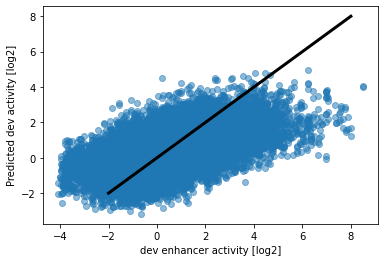

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as lines

plt.scatter(labels[:,0], predictions[:,0], alpha=0.5)
plt.plot([-2,8], [-2,8], lw=3, color="black")
plt.xlabel("dev enhancer activity [log2]")
plt.ylabel("Predicted dev activity [log2]")
plt.show()

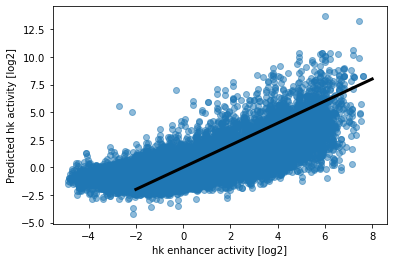

In [30]:
%matplotlib inline
plt.scatter(labels[:,1], predictions[:,1], alpha=0.5)
plt.plot([-2,8], [-2,8], lw=3, color="black")
plt.xlabel("hk enhancer activity [log2]")
plt.ylabel("Predicted hk activity [log2]")
plt.show()

# Interpretation

In [34]:
data = h5py.File("../../DeepSTARR_data/DeepSTARR_data.h5", 'r')

x = torch.Tensor(np.array(data['train_in']))
y = torch.Tensor(np.array(data['valid_in']))
z = torch.Tensor(np.array(data['test_in']))

x_lab = torch.Tensor(np.array(data['train_out']))
y_lab = torch.Tensor(np.array(data['valid_out']))
z_lab = torch.Tensor(np.array(data['test_out']))

res = torch.cat((z,), dim=0)
res_lab = torch.cat((z_lab,), dim=0)

all_dataset = torch.utils.data.TensorDataset(res, res_lab)
dataloader_test = torch.utils.data.DataLoader(all_dataset, 
                                                  batch_size=128, shuffle=False,
                                                  num_workers=0)

In [37]:
activations = interpretation.get_explainn_unit_activations(dataloader_test, model, device)
pwms = interpretation.get_pwms_explainn(activations, res, res_lab, filter_size)
interpretation.pwm_to_meme(pwms, "../CAM_DeepSTARR.meme")

100%|██████████| 300/300 [02:49<00:00,  1.77it/s]  


# Interactions

In [39]:
from Bio import motifs

with open("../../DeepSTARR_data/HK_TFs.meme") as handle:
    hk_motifs = motifs.parse(handle, "jaspar")

#Ohler1 - homer__MYGGTCACACTG_Unknown1 "ACGGTCACACTG"
#Ohler6 - homer__AAAAATACCRMA_Unknown4 "AAAAATACCAAA"
#Dref   - homer__AVYTATCGATAD_DREF     "AACTATCGATAG"
    
for m in hk_motifs:
    if m.base_id == "homer__AVYTATCGATAD_DREF": #Dref
        print(m.consensus)

AACTATCGATAG


In [40]:
consensus = ["ACGGTCACACTG", "AAAAATACCAAA", "AACTATCGATAG", "GGGCT"]

code = {"A":0,"C":1,"G":2,"T":3}
motif = [torch.tensor([code[i] for i in j]) for j in consensus]

y = torch.eye(4)

motifs_one_hot = []
for i in motif:
    motifs_one_hot.append(torch.transpose(y[i], 0, 1))

In [41]:
motifs = pd.Series(motifs_one_hot, index=['Ohler1', 'Ohler6', 'Dref', 'cntrl'])

population = torch.randint(0,4,(60, 249),dtype=torch.long)

y = torch.eye(4)
random_seq = torch.transpose(y[population], 1, 2)

## DeepSTARR

In [43]:
deepstarr_model = networks.DeepSTARR().to(device)
deepstarr_model.load_state_dict(torch.load("../../DeepSTARR_results/model_epoch_8_.pth"))
deepstarr_model.eval();

In [46]:
#(1) without any motif (b), 
#(2) only with MotifAin the center (A), 
#(3) only with MotifBd-bases up-or downstream (B) 
#(4) with both MotifAand MotifB(AB).
#0-25; 25-50; 50-75; 75-100; 100-125
#cooperativity = AB/(A+B-b)

res_final = {}
dist = list(range(0,105,1))+list(range(140,235,1))

for m1 in tqdm(motifs.index):
    
    res = np.zeros((4,len(dist)))
    MOTIF1 = m1
    
    for m2 in range(len(motifs.index)):
        
        MOTIF2 = motifs.index[m2]
        
        for i in range(len(dist)):
            #b
            temp_b = copy.deepcopy(random_seq)

            #A
            temp_A = copy.deepcopy(random_seq)
            temp_A[:,:,125:(125+motifs[MOTIF1].shape[1])] = motifs[MOTIF1]

            #B
            temp_B = copy.deepcopy(random_seq)
            temp_B[:,:,dist[i]:(dist[i]+motifs[MOTIF2].shape[1])] = motifs[MOTIF2]

            #AB
            temp_AB = copy.deepcopy(random_seq)
            temp_AB[:,:,125:(125+motifs[MOTIF1].shape[1])] = motifs[MOTIF1]
            temp_AB[:,:,dist[i]:(dist[i]+motifs[MOTIF2].shape[1])] = motifs[MOTIF2]

            cnn_output_b = deepstarr_model(temp_b.to(device))
            cnn_output_b = cnn_output_b.detach().cpu().numpy()

            cnn_output_A = deepstarr_model(temp_A.to(device))
            cnn_output_A = cnn_output_A.detach().cpu().numpy()

            cnn_output_B = deepstarr_model(temp_B.to(device))
            cnn_output_B = cnn_output_B.detach().cpu().numpy()

            cnn_output_AB = deepstarr_model(temp_AB.to(device))
            cnn_output_AB = cnn_output_AB.detach().cpu().numpy()

            diff = cnn_output_AB/(cnn_output_A+cnn_output_B-cnn_output_b)
            cooperativity = np.median(diff[:,1],axis=0)
            res[m2,i] = cooperativity
            
    res_final[m1] = res

100%|██████████| 4/4 [00:18<00:00,  4.71s/it]


In [47]:
res_final = pd.Series(res_final)
res_final_deepstarr = res_final

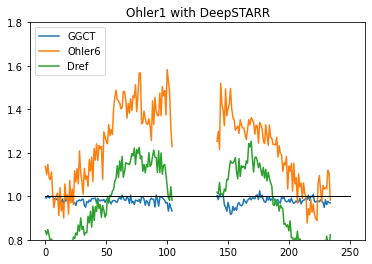

In [48]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

t1 = np.arange(0, 105, 1)
mask_start = len(t1)
t2 = np.arange(140, 235, 1)
t = np.concatenate([t1, t2])

c = res_final_deepstarr['Ohler1'][3,:] #ctrl
c1 = res_final_deepstarr['Ohler1'][0,:] #Ohler1
c2 = res_final_deepstarr['Ohler1'][1,:] #Ohler6
c3 = res_final_deepstarr['Ohler1'][2,:] #Dref

mc = ma.array(c)
mc[mask_start] = ma.masked
mc1 = ma.array(c1)
mc1[mask_start] = ma.masked
mc2 = ma.array(c2)
mc2[mask_start] = ma.masked
mc3 = ma.array(c3)
mc3[mask_start] = ma.masked
plt.figure()
plt.plot(t, mc,label="GGCT")
#plt.plot(t, mc1,label="Ohler1")
plt.plot(t, mc2,label="Ohler6")
plt.plot(t, mc3,label="Dref")
plt.plot([0,250], [1,1], lw=1, color="black")
plt.title('Ohler1 with DeepSTARR')
plt.legend(loc="upper left")
plt.ylim((0.8, 1.8))
plt.show()

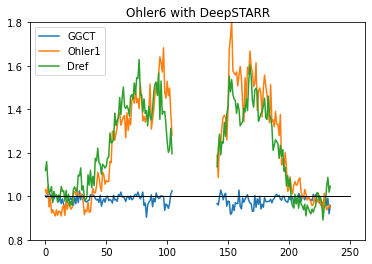

In [49]:
c = res_final_deepstarr['Ohler6'][3,:] #ctrl
c1 = res_final_deepstarr['Ohler6'][0,:] #Ohler1
c2 = res_final_deepstarr['Ohler6'][1,:] #Ohler6
c3 = res_final_deepstarr['Ohler6'][2,:] #Dref

mc = ma.array(c)
mc[mask_start] = ma.masked
mc1 = ma.array(c1)
mc1[mask_start] = ma.masked
mc2 = ma.array(c2)
mc2[mask_start] = ma.masked
mc3 = ma.array(c3)
mc3[mask_start] = ma.masked
plt.figure()
plt.plot(t, mc,label="GGCT")
plt.plot(t, mc1,label="Ohler1")
#plt.plot(t, mc2,label="Ohler6")
plt.plot(t, mc3,label="Dref")
plt.plot([0,250], [1,1], lw=1, color="black")
plt.title('Ohler6 with DeepSTARR')
plt.legend(loc="upper left")
plt.ylim((0.8, 1.8))
plt.show()

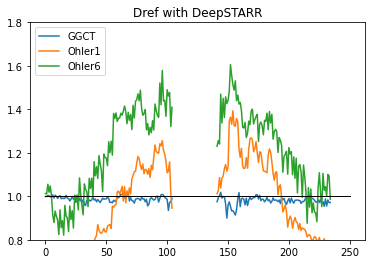

In [50]:
c = res_final_deepstarr['Dref'][3,:] #ctrl
c1 = res_final_deepstarr['Dref'][0,:] #Ohler1
c2 = res_final_deepstarr['Dref'][1,:] #Ohler6
c3 = res_final_deepstarr['Dref'][2,:] #Dref

mc = ma.array(c)
mc[mask_start] = ma.masked
mc1 = ma.array(c1)
mc1[mask_start] = ma.masked
mc2 = ma.array(c2)
mc2[mask_start] = ma.masked
mc3 = ma.array(c3)
mc3[mask_start] = ma.masked
plt.figure()
plt.plot(t, mc,label="GGCT")
plt.plot(t, mc1,label="Ohler1")
plt.plot(t, mc2,label="Ohler6")
#plt.plot(t, mc3,label="Dref")
plt.plot([0,250], [1,1], lw=1, color="black")
plt.title('Dref with DeepSTARR')
plt.legend(loc="upper left")
plt.ylim((0.8, 1.8))
plt.show()

## ExplaiNN

In [51]:
model

ExplaiNN(
  (linears): Sequential(
    (0): Conv1d(1200, 300, kernel_size=(20,), stride=(1,), groups=300)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): exp_activation_module()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Unsqueeze()
    (6): Conv1d(9600, 30000, kernel_size=(1,), stride=(1,), groups=300)
    (7): BatchNorm1d(30000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(30000, 300, kernel_size=(1,), stride=(1,), groups=300)
    (11): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=300, out_features=2, bias=True)
)

In [52]:
res_final = {}
dist = list(range(0,105,1))+list(range(140,235,1))

for m1 in tqdm(motifs.index):
    
    res = np.zeros((4,len(dist)))
    MOTIF1 = m1
    
    for m2 in range(len(motifs.index)):
        
        MOTIF2 = motifs.index[m2]
        
        for i in range(len(dist)):
            #b
            temp_b = copy.deepcopy(random_seq)

            #A
            temp_A = copy.deepcopy(random_seq)
            temp_A[:,:,125:(125+motifs[MOTIF1].shape[1])] = motifs[MOTIF1]

            #B
            temp_B = copy.deepcopy(random_seq)
            temp_B[:,:,dist[i]:(dist[i]+motifs[MOTIF2].shape[1])] = motifs[MOTIF2]

            #AB
            temp_AB = copy.deepcopy(random_seq)
            temp_AB[:,:,125:(125+motifs[MOTIF1].shape[1])] = motifs[MOTIF1]
            temp_AB[:,:,dist[i]:(dist[i]+motifs[MOTIF2].shape[1])] = motifs[MOTIF2]

            cnn_output_b = model(temp_b.to(device))
            cnn_output_b = cnn_output_b.detach().cpu().numpy()

            cnn_output_A = model(temp_A.to(device))
            cnn_output_A = cnn_output_A.detach().cpu().numpy()

            cnn_output_B = model(temp_B.to(device))
            cnn_output_B = cnn_output_B.detach().cpu().numpy()

            cnn_output_AB = model(temp_AB.to(device))
            cnn_output_AB = cnn_output_AB.detach().cpu().numpy()

            diff = cnn_output_AB/(cnn_output_A+cnn_output_B-cnn_output_b)
            cooperativity = np.median(diff[:,1],axis=0)
            res[m2,i] = cooperativity
            
    res_final[m1] = res

100%|██████████| 4/4 [03:11<00:00, 47.87s/it]


In [53]:
res_final = pd.Series(res_final)
res_final_cam = res_final

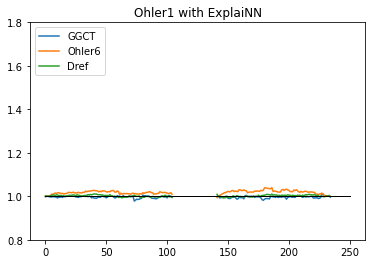

In [54]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

t1 = np.arange(0, 105, 1)
mask_start = len(t1)
t2 = np.arange(140, 235, 1)
t = np.concatenate([t1, t2])

c = res_final_cam['Ohler1'][3,:] #ctrl
c1 = res_final_cam['Ohler1'][0,:] #Ohler1
c2 = res_final_cam['Ohler1'][1,:] #Ohler6
c3 = res_final_cam['Ohler1'][2,:] #Dref

mc = ma.array(c)
mc[mask_start] = ma.masked
mc1 = ma.array(c1)
mc1[mask_start] = ma.masked
mc2 = ma.array(c2)
mc2[mask_start] = ma.masked
mc3 = ma.array(c3)
mc3[mask_start] = ma.masked
plt.figure()
plt.plot(t, mc,label="GGCT")
#plt.plot(t, mc1,label="Ohler1")
plt.plot(t, mc2,label="Ohler6")
plt.plot(t, mc3,label="Dref")
plt.plot([0,250], [1,1], lw=1, color="black")
plt.title('Ohler1 with ExplaiNN')
plt.legend(loc="upper left")
plt.ylim((0.8, 1.8))
plt.show()

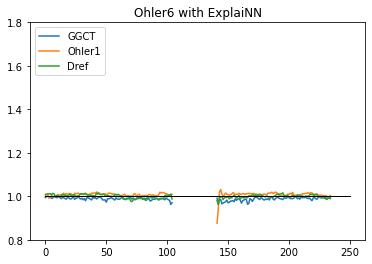

In [55]:
c = res_final_cam['Ohler6'][3,:] #ctrl
c1 = res_final_cam['Ohler6'][0,:] #Ohler1
c2 = res_final_cam['Ohler6'][1,:] #Ohler6
c3 = res_final_cam['Ohler6'][2,:] #Dref

mc = ma.array(c)
mc[mask_start] = ma.masked
mc1 = ma.array(c1)
mc1[mask_start] = ma.masked
mc2 = ma.array(c2)
mc2[mask_start] = ma.masked
mc3 = ma.array(c3)
mc3[mask_start] = ma.masked
plt.figure()
plt.plot(t, mc,label="GGCT")
plt.plot(t, mc1,label="Ohler1")
#plt.plot(t, mc2,label="Ohler6")
plt.plot(t, mc3,label="Dref")
plt.plot([0,250], [1,1], lw=1, color="black")
plt.title('Ohler6 with ExplaiNN')
plt.legend(loc="upper left")
plt.ylim((0.8, 1.8))
plt.show()

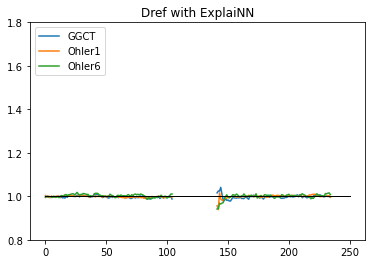

In [56]:
c = res_final_cam['Dref'][3,:] #ctrl
c1 = res_final_cam['Dref'][0,:] #Ohler1
c2 = res_final_cam['Dref'][1,:] #Ohler6
c3 = res_final_cam['Dref'][2,:] #Dref

mc = ma.array(c)
mc[mask_start] = ma.masked
mc1 = ma.array(c1)
mc1[mask_start] = ma.masked
mc2 = ma.array(c2)
mc2[mask_start] = ma.masked
mc3 = ma.array(c3)
mc3[mask_start] = ma.masked
plt.figure()
plt.plot(t, mc,label="GGCT")
plt.plot(t, mc1,label="Ohler1")
plt.plot(t, mc2,label="Ohler6")
#plt.plot(t, mc3,label="Dref")
plt.plot([0,250], [1,1], lw=1, color="black")
plt.title('Dref with ExplaiNN')
plt.legend(loc="upper left")
plt.ylim((0.8, 1.8))
plt.show()